In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/nbhd_volumes.*pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/nbhd_volumes_l0.pkl',


In [10]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [11]:
# # fix issues where antibody names aren't consistent accross some images
# channel_to_idents = {
#     'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
#     'E-cadherin': ['E-cadherin', 'E-Cadherin'],
#     'CD45': ['CD45'],
#     'CD45RO': ['CD45RO'],
#     'CD45RA': ['CD45RA'],
#     'CD8': ['CD8', 'CD8a'],
#     'DAPI': ['DAPI'],
#     'CD4': ['CD4'],
#     'CD3e': ['CD3e', 'CD3'],
#     'Vimentin': ['Vimentin', 'Vim', 'VIM'],
#     'SMA': ['SMA', 'a-SMA'],
#     'CD31': ['CD31'],
#     'CD20': ['CD20', 'CD20-Akoya'],
#     'CD68': ['CD68'],
#     'CD163': ['CD163'],
#     'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
#     'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
#     'MGP': ['MGP'],
#     'CD36': ['CD36'],
#     'PR': ['PR'],
#     'ER': ['ER'],
#     'P21': ['P21'],
#     'P16': ['P16'],
#     'CK5': ['Keratin 5', 'KRT5', 'CK5'],
#     'CK7': ['CK7'],
#     'CK8/18': ['CK8/18'],
#     'TFF1': ['TFF1'],
#     'beta-integrin': ['beta-integrin', 'beta3-integrin'],
#     'CK14': ['CK14', 'Keratin 14', 'KRT14'],
#     'CK17': ['CK17', 'Keratin 17', 'CK17'],
#     'CK19': ['CK19', 'Keratin 19', 'KRT19'],
#     'CD11b': ['CD11b', 'CD11B', 'cd11b'],
#     'GATA3': ['GATA3'],
#     'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
#     'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
#     'Her2': ['Her2', 'HER2'],
#     'Bap1': ['Bap1', 'BAP1'],
#     'GLUT1': ['Glut1', 'GLUT1'],
#     'CD11c': ['CD11c'],
#     'HLA-DR': ['HLA-DR', 'HLADR'],
#     'Ki67': ['Ki67', 'KI67'],
#     'Podoplanin': ['Podoplanin', 'PDPN'],
#     'CTLA4': ['CTLA4'],
#     'SLC39A6': ['SLC39A6'],
#     'BCA1': ['BCA1'],
#     'BCAL': ['BCAL'],
#     'TUBB3': ['TUBB3'],
#     'PTPRZ1': ['PTPRZ1'],
#     'HIF1A': ['HIF1a', 'HIF1A'],
#     'PAI1': ['PAI1'],
#     'GFAP': ['GFAP'],
#     'VEGFA': ['VEGFA'],
#     'IBA1': ['IBA1'],
#     'OLIG2': ['OLIG2'],
#     'FN1': ['FN1'],
#     'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
#     'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
#     'Granzyme-B': ['Granzyme B', 'GZMB'],
#     'TCF-1': ['TCF-1'],
#     'CD39': ['CD39'],
#     'PD1': ['PD-1', 'PD1'],
#     'PDL1': ['PD-L1', 'PDL1'],
#     'Histone-H3-Pho': ['Histone H3 Pho'],
#     'Maspin': ['Maspin'],
#     'MMP9': ['MMP9'],
#     'CD44': ['CD44'],
#     'CD107A': ['CD107a'],
#     'FGFR3': ['FGFR3'],
#     'CD138': ['CD138'],
#     'MLPH': ['MLPH'],
#     'P63': ['P63', 'p63'],
#     'GP2': ['GP2'],
#     'COX2': ['COX2'],
#     'Lyve-1': ['Lyve-1', 'LYVE1'],
#     'CCL2': ['CCL2'],
#     'MUC2': ['MUC2'],
#     'SOX9': ['SOX9'],
#     'STEAP4': ['STEAP4'],
#     'AR': ['AR'],
#     'AMACR': ['AMACR'],
#     'PGC': ['PGC', 'PGC (D)'],
#     'CFTR': ['CFTR (D)', 'CFTR'],
#     'REG3A': ['REG3A (D)', 'REG3A'],
#     'LAMC2': ['LAMC2 (D)', 'LAMC2'],
#     'INS': ['INS (D)', 'INS'],
#     'CRP': ['CRP (D)', 'CRP'],
#     'CD74': ['CD74 (D)', 'CD74'],
#     'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
#     'AQP1': ['AQP1'],
#     'AQP2': ['Aqp2', 'AQP2'], 
#     'LRP2': ['LRP2'],
#     'UMOD': ['UMOD'],
#     'CALB1': ['CALB1'],
#     'CP': ['CP'],
#     'CA9': ['CA9'],
#     'UCHL1': ['UCHL1'],
# }
# channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# # add in (D) variants
# variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
# channel_mapping.update({k + variant:v
#                       for k, v in channel_mapping.items()
#                       for variant in variants})

In [12]:
exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [13]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-5591-C8', 'S18-9906'])

In [14]:
case_meta = pd.read_csv(os.path.join(output_dir, 'case_metadata.txt'), sep='\t')
case_meta = case_meta[[True if x not in exclude else False for x in case_meta['case']]]
case_meta['n_sections'] = [len(case_to_sections[x]) for x in case_meta['case']]
case_to_disease = {k:v for k, v in zip(case_meta['case'], case_meta['tissue_type'])}
    
case_meta

,case,tissue_type,cohort,n_sections
1,C3L-00982,CCRCC,inhouse,5
2,C3L-01287,CCRCC,inhouse,2
3,C3L-02551,CCRCC,inhouse,5
4,HT206B1,BRCA,inhouse,15
5,HT225C1,CRC,inhouse,4
6,HT268B1,BRCA,inhouse,4
7,HT339B2-H1,BRCA,inhouse,2
8,HT397B1,BRCA,inhouse,12
9,HT413C1-K2,CRC,inhouse,2
10,HT413C1-Th1k4A1,CRC,inhouse,28


In [15]:
case_order = case_meta.sort_values(['tissue_type', 'n_sections'])['case'].to_list()
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [16]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/outputs.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/ou

In [17]:
case_to_specific = {}
case_to_integrated = {}
for fp in fps:
    case = fp.split('/')[-3]
    if case in case_order:
        outputs = pickle.load(open(fp, 'rb'))
        dtype_to_specific = outputs['dtype_to_cluster_intensities']['dtype_specific'][-1]
        dtype_to_integrated = outputs['dtype_to_cluster_intensities']['integrated'][-1]
        
        case_to_specific[case] = dtype_to_specific
        case_to_integrated[case] = dtype_to_integrated
        
        
#         nbhd_outputs = pickle.load(open(
#             os.path.join(project_dir, case, 'mushroom_50res', 'nbhd_outputs.pkl', 'rb'))
        
                                   
                                   
                                   
                                   

In [18]:
# case = 'C3L-00982'
case = 'HT397B1'
mushroom = Mushroom.from_config(os.path.join(project_dir, case, 'mushroom_50res'))

INFO:root:loading spore for batch2_he
INFO:root:data mask detected
INFO:root:starting batch2_he processing
INFO:root:6 sections detected: ['HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U4


0.007287140063108625


INFO:root:generating image data for section HT397B1-U8
INFO:root:generating image data for section HT397B1-U11
INFO:root:generating image data for section HT397B1-U16
INFO:root:generating image data for section HT397B1-U20
INFO:root:generating image data for section HT397B1-U28
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT397B1-U4', 'batch2_he'), ('HT397B1-U8', 'batch2_he'), ('HT397B1-U11', 'batch2_he'), ('HT397B1-U16', 'batch2_he'), ('HT397B1-U20', 'batch2_he'), ('HT397B1-U28', 'batch2_he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpqwzsw8wq
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpqwzsw8wq/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


batch2_he torch.Size([3, 135, 133])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/batch2_he_chkpts/last-v1.ckpt
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U1


0.007287140063108625


INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT397B1-U1', 'he'), ('HT397B1-U21', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/he_chkpts/last-v1.ckpt


he torch.Size([3, 135, 133])


INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U2


0.007287140063108625


INFO:root:generating image data for section HT397B1-U12
INFO:root:generating image data for section HT397B1-U22
INFO:root:generating image data for section HT397B1-U31
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT397B1-U2', 'multiplex'), ('HT397B1-U12', 'multiplex'), ('HT397B1-U22', 'multiplex'), ('HT397B1-U31', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/multiplex_chkpts/last-v1.ckpt
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([24, 135, 133])


INFO:root:using 9675 channels
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections


ppm 0.36435700315543124 target_ppm 100
tiling size 274


INFO:root:generating image data for section HT397B1-U1
INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT397B1-U1', 'visium'), ('HT397B1-U21', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT


visium torch.Size([9675, 69, 68])


INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/visium_chkpts/last-v1.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding batch2_he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

In [19]:
outputs = pickle.load(open(os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

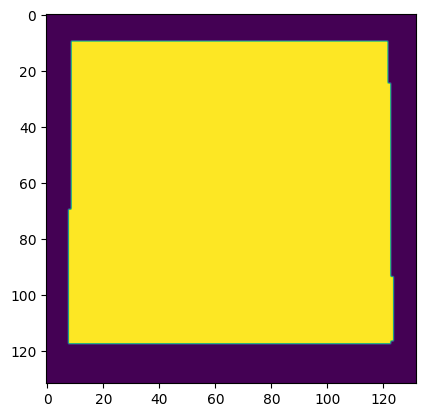

In [33]:
mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
tissue_mask = tifffile.imread(mask_fp)
target_size  = outputs['dtype_to_clusters']['integrated'][0].shape[1:]
tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
plt.imshow(tissue_mask)

In [35]:
level_to_dtype_to_volume = {}
for i in range(3):
    v = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l{i}.pkl'), 'rb'))['labeled']
    level_to_dtype_to_volume[i] = v

In [77]:
v_params = yaml.safe_load(open(os.path.join(project_dir, case, 'mushroom_50res', 'nbhd_volume_params.yaml')))
z_sf = 50. * v_params['z_scaler']
z_sf

10.0

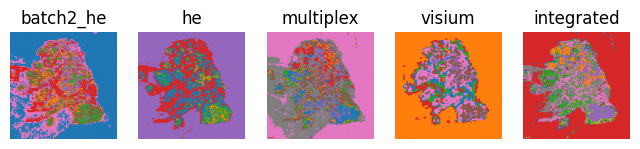

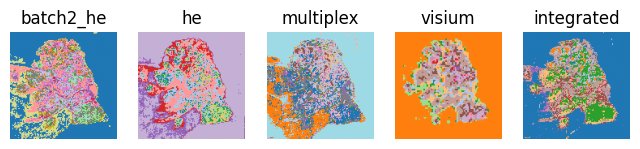

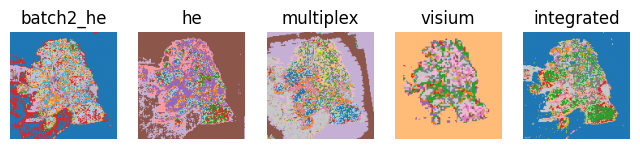

In [36]:
for i in range(mushroom.num_levels):
    mushroom.display_volumes(positions=[2], dtype_to_volume=level_to_dtype_to_volume[i], figsize=(8, 4))
    plt.show()

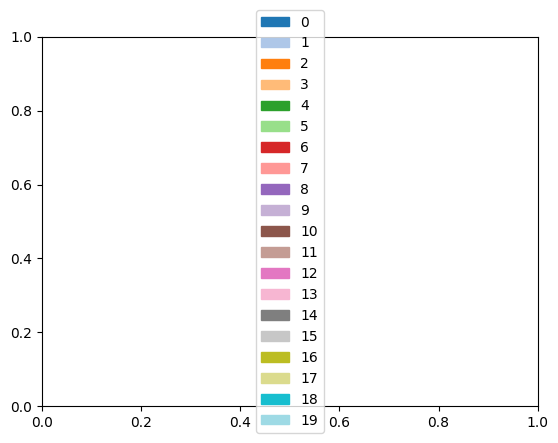

In [240]:
cmap = vis_utils.get_cmap(level_to_dtype_to_volume[2]['integrated'].max())
vis_utils.display_legend(np.unique(level_to_dtype_to_volume[2]['integrated']), cmap)

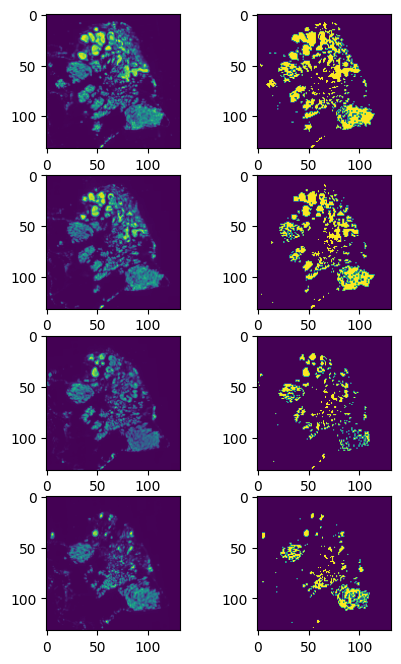

In [41]:
thresh = 1.5
spore = mushroom.dtype_to_spore['multiplex']
idx = spore.learner_data.dtype_to_channels['multiplex'].index('Pan-Cytokeratin')
nrows = len(spore.true_pixels)
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(5, nrows * 2))
if nrows == 1:
    axs = rearrange(axs, 'n -> 1 n')

for i, tp in enumerate(spore.true_pixels):
    img = tp[..., idx]
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img > thresh)

In [45]:
tumor_mask = np.stack(spore.true_pixels)[..., idx] > thresh
tumor_mask.shape

(4, 132, 132)

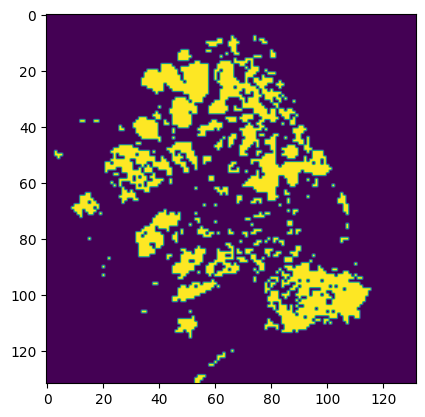

In [459]:
plt.imshow(tumor_mask[0])

In [103]:
positions = [pos for pos, (sid, dtype) in zip(mushroom.section_positions, mushroom.section_ids)
            if dtype == 'multiplex']
positions

[1, 11, 21, 30]

In [104]:
level_to_dtype_to_volume[2]['integrated'][positions].shape

(4, 132, 132)

In [445]:
from collections import Counter
volume = level_to_dtype_to_volume[2]['integrated']
data, labels = [], np.unique(volume)
for label in labels:
    masks = volume==label
    contacts = []
    for m, v in zip(masks, volume):
        expanded = skimage.morphology.binary_dilation(m)
        contacts += [l for l in v[expanded] if l != label]
    counts = Counter(contacts)
    data.append([counts.get(l, 0) for l in labels])
contact_df = pd.DataFrame(data=data, columns=labels, index=labels)
contact_df /= np.expand_dims(contact_df.sum(1).values, -1)
contact_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.024098,0.012809,0.024408,0.008436,0.002636,0.012405,0.040069,0.011754,0.004125,0.004280,0.026641,0.066245,0.011940,0.036999,0.281944,0.429816,0.000186,0.000341,0.000868
1,0.057937,0.000000,0.181549,0.148485,0.182503,0.025778,0.002110,0.042812,0.002713,0.023717,0.045375,0.007035,0.127280,0.018944,0.059444,0.036028,0.036179,0.000352,0.000904,0.000854
2,0.064287,0.453051,0.000000,0.094123,0.128575,0.015537,0.003603,0.022517,0.004278,0.006417,0.027246,0.002252,0.101666,0.007543,0.026008,0.020603,0.022292,0.000000,0.000000,0.000000
3,0.026370,0.075595,0.022422,0.000000,0.089515,0.035650,0.115742,0.168425,0.002824,0.000721,0.090466,0.044469,0.119776,0.064557,0.038561,0.058015,0.045478,0.000173,0.000317,0.000922
4,0.009627,0.118498,0.036036,0.129343,0.000000,0.210701,0.041288,0.023365,0.000381,0.041592,0.169261,0.006317,0.028464,0.010655,0.157616,0.010427,0.006165,0.000190,0.000076,0.000000
5,0.005155,0.028028,0.007625,0.071091,0.379081,0.000000,0.075279,0.048540,0.001128,0.016967,0.078769,0.021209,0.016377,0.022981,0.207045,0.013424,0.006927,0.000000,0.000054,0.000322
6,0.025533,0.002346,0.001146,0.235201,0.065906,0.078891,0.000000,0.175405,0.003983,0.000000,0.040810,0.190791,0.012439,0.036227,0.018823,0.060996,0.051285,0.000000,0.000109,0.000109
7,0.046124,0.025849,0.005917,0.207107,0.020337,0.029524,0.098508,0.000000,0.011461,0.000810,0.030708,0.081784,0.062817,0.115731,0.052415,0.097044,0.111807,0.001028,0.000779,0.000249
8,0.191237,0.017824,0.013368,0.037133,0.003713,0.007798,0.028593,0.144077,0.000000,0.000000,0.021166,0.011140,0.021166,0.043075,0.010397,0.150390,0.297438,0.001485,0.000000,0.000000
9,0.032002,0.137638,0.016992,0.007080,0.393656,0.089776,0.000000,0.007080,0.000000,0.000000,0.004815,0.006231,0.017559,0.008779,0.227981,0.032285,0.018125,0.000000,0.000000,0.000000


In [458]:
from collections import Counter
volume = level_to_dtype_to_volume[2]['integrated']
data, labels = [], np.unique(volume)
for label in labels:
    contacts = 0
    for m, v in zip(tumor_mask, volume):
        expanded = skimage.morphology.binary_dilation(m)
        boundary = expanded ^ m
        contacts += (v[boundary] == label).sum()
    data.append(contacts)
contact_df = pd.DataFrame(data=data, index=labels)
contact_df /= contact_df.sum()
contact_df

,0
0,0.050924
1,0.040482
2,0.021526
3,0.070201
4,0.225703
5,0.135743
6,0.055743
7,0.038554
8,0.000161
9,0.029076


In [433]:
import skimage
def get_profiles(volume, label_volume, mask, tumor_dist=0., tme_dist=5., n=1000, z_sf=10.):
    max_bounds = np.asarray(mask.shape) - 1
    min_bounds = (0, 0, 0)
    
    verts, faces, normals, values = skimage.measure.marching_cubes(mask)
    
    idxs = np.random.choice(np.arange(verts.shape[0]), size=n, replace=True)
    profiles = []
    label_profiles = []
    for idx in idxs:
        start = verts[idx]
        stop = start.copy()
        stop[0] = start[0] + (normals[idx][0] * (tme_dist / z_sf)) # depth direction needs to be scaled
        stop[1:] = start[1:] + (normals[idx][1:] * tme_dist)
        
        start[0] = start[0] - (normals[idx][0] * (tumor_dist / z_sf)) # depth direction needs to be scaled
        start[1:] = start[1:] - (normals[idx][1:] * tumor_dist)
        
        if (stop > max_bounds).sum() == 0 and (stop < min_bounds).sum() == 0:
            if (start > max_bounds).sum() == 0 and (start < min_bounds).sum() == 0:
                line = skimage.draw.line_nd(start, stop, integer=True)
                profile = volume[line]
                profile = np.pad(profile, ((0, int(tumor_dist + tme_dist) - len(profile)), (0, 0)))
                profiles.append(profile)

                profile = label_volume[line]
                profile = np.pad(profile, (0, int(tumor_dist + tme_dist) - len(profile)))
                label_profiles.append(profile)
    
    return np.stack(profiles), np.stack(label_profiles)

# profiles, label_profiles = get_profiles(
#     np.stack(spore.true_pixels), level_to_dtype_to_volume[2]['integrated'][positions], tumor_mask)
profiles, label_profiles = get_profiles(
    np.stack(spore.predicted_pixels[2]), level_to_dtype_to_volume[2]['integrated'][positions], tumor_mask)
# profiles, label_profiles = get_profiles(
#     np.stack(spore.predicted_pixels[2]), level_to_dtype_to_volume[2]['multiplex'][positions], tumor_mask)
profiles.shape, label_profiles.shape

((922, 5, 24), (922, 5))

In [434]:
# x = rearrange(profiles, 'n bin c -> n (bin c)')
# # x = profiles.mean(1)
# # x = profiles[:, 0]
# cg = sns.clustermap(x, col_cluster=False)

In [435]:
# profiles = profiles[cg.dendrogram_row.reordered_ind]
# label_profiles = label_profiles[cg.dendrogram_row.reordered_ind]
# profiles.shape, label_profiles.shape

In [436]:
data = []
labels = np.unique(label_profiles)
count_df = pd.DataFrame(np.zeros((len(label_profiles), len(labels)), dtype=int), columns=labels)
for i, profile in enumerate(label_profiles):
    for j, l in enumerate(profile):
        count_df.loc[i, l] += 1
count_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
0,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,1,0,0
3,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,2,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,2,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
918,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
919,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
920,0,0,0,2,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0


[1, 2, 6, 12, 3, 4, 10, 0, 8, 5, 11, 15, 16, 9, 13, 14, 18, 7, 17, 19]

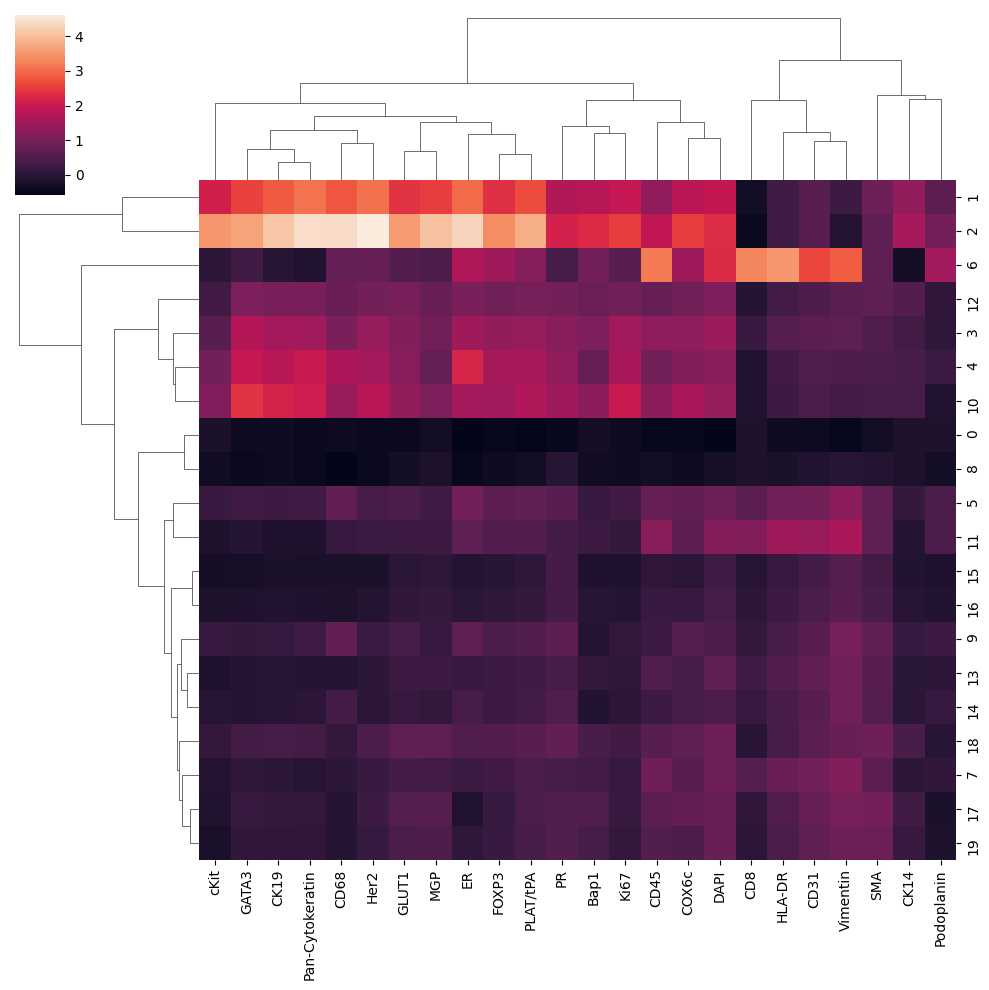

In [437]:
df = outputs['dtype_to_cluster_intensities']['integrated'][2]['multiplex']
# df = df[[c for c in df.columns if c not in [
#     'DAPI', 'CD45'
# ]]]
cg = sns.clustermap(df)
label_order = cg.dendrogram_row.reordered_ind
label_order

In [438]:
sort_df = pd.DataFrame(np.stack(([1,2,3],[4,5,6])).T)
sort_df

,0,1
0,1,4
1,2,5
2,3,6


In [439]:
# max_labels = count_df.columns[count_df.values.argmax(1)].to_list()
# first_labels = label_profiles[:, 0]

# max_labels_idx = [label_order.index(x) for x in max_labels]
# first_labels_idx = [label_order.index(x) for x in first_labels]

# sort_df = pd.DataFrame(data=np.stack((first_labels_idx, max_labels_idx)).T)
# idxs = sort_df.sort_values(by=list(sort_df.columns)).index.to_list()

# label_profiles = label_profiles[idxs]

In [440]:
# max_labels = count_df.columns[count_df.values.argmax(1)]
# idxs = np.argsort([label_order.index(x) for x in max_labels])
# label_profiles = label_profiles[idxs]
# # sorted(max_labels, key=lambda x: label_order.index(x))

In [441]:
# # background = [0]
# # label_order = count_df.sum(0).sort_values(ascending=False).index.to_list()
# count_df = count_df.sort_values([l for l in label_order if l in count_df.columns], ascending=False)
# label_profiles = label_profiles[count_df.index.to_list()]

In [442]:
# n = 10.
# weights = np.flip(np.arange(1, label_profiles.shape[1] + 1) * n)
weights = np.asarray([1., .2, .1, .05, .01])
ordering = np.vectorize(label_order.index)(label_profiles).astype(float)
ordering /= ordering.max()
idxs = np.argsort((ordering * weights).sum(1))
label_profiles = label_profiles[idxs]

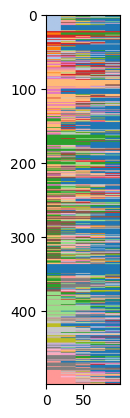

In [443]:
labeled = utils.rescale(label_profiles, size=(500, 100), dim_order='h w', target_dtype=int, antialias=False, interpolation=TF.InterpolationMode.NEAREST)
rgb = vis_utils.display_labeled_as_rgb(labeled)
plt.imshow(rgb)

In [421]:
import torchvision.transforms.functional as TF

In [258]:
dtype_to_df = mushroom.calculate_cluster_intensities(
    level=2, projection_dtype='integrated', dtype_to_volume=level_to_dtype_to_volume[2], use_predicted=False)
dtype_to_df.keys()

dict_keys(['batch2_he', 'he', 'multiplex', 'visium'])

In [259]:
dtype_to_df['multiplex'][['Pan-Cytokeratin']]

,Pan-Cytokeratin
0,-0.434623
1,3.438769
2,4.468661
3,1.689319
4,2.110534
5,0.400373
6,-0.106279
7,0.071598
8,-0.309054
9,0.305129


In [260]:
dtype_to_df['visium'][['EPCAM']]

,EPCAM
0,-0.493039
1,1.885840
2,2.433446
3,0.334307
4,2.359307
5,1.679420
6,0.230122
7,0.084881
8,-0.161663
9,3.133486


In [261]:
threshold = 1.
seeds = [i for i, val in zip(dtype_to_df['multiplex'].index, dtype_to_df['multiplex']['Pan-Cytokeratin'])
        if val > threshold]
seeds

[1, 2, 3, 4, 10, 12]

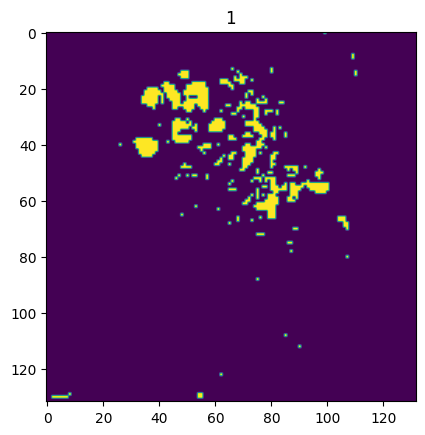

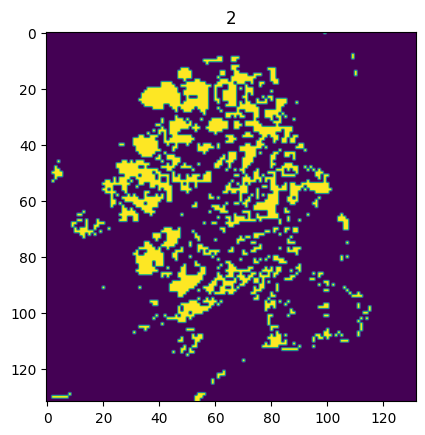

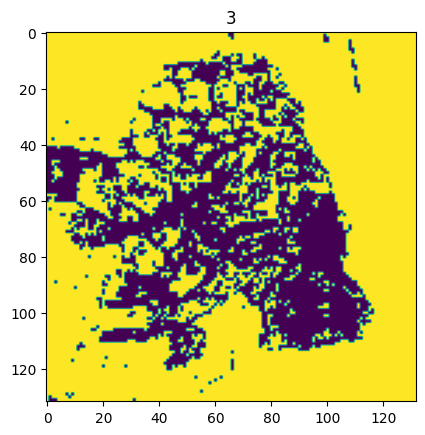

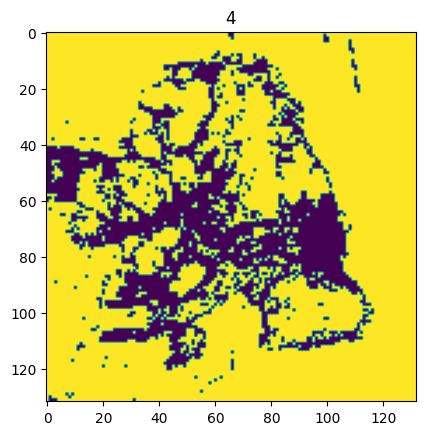

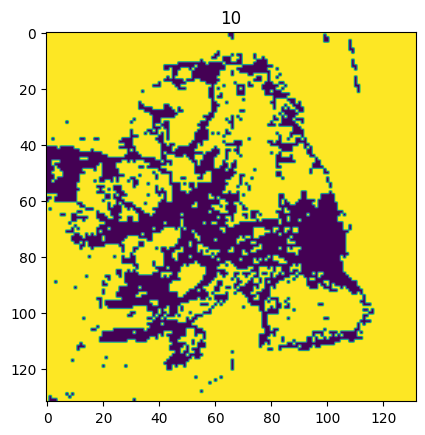

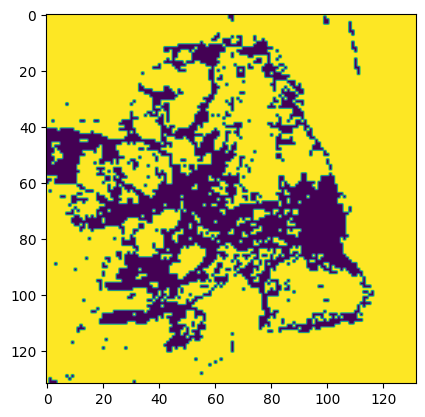

In [256]:
v = level_to_dtype_to_volume[0]['integrated'][section_idx]
mask = np.zeros_like(v, dtype=bool)
for label in seeds:
    mask |= v==label
    plt.imshow(mask)
    plt.title(label)
    plt.show()
plt.imshow(mask)

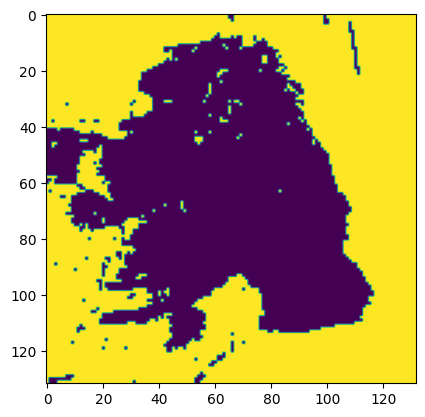

In [257]:
plt.imshow(v==3)

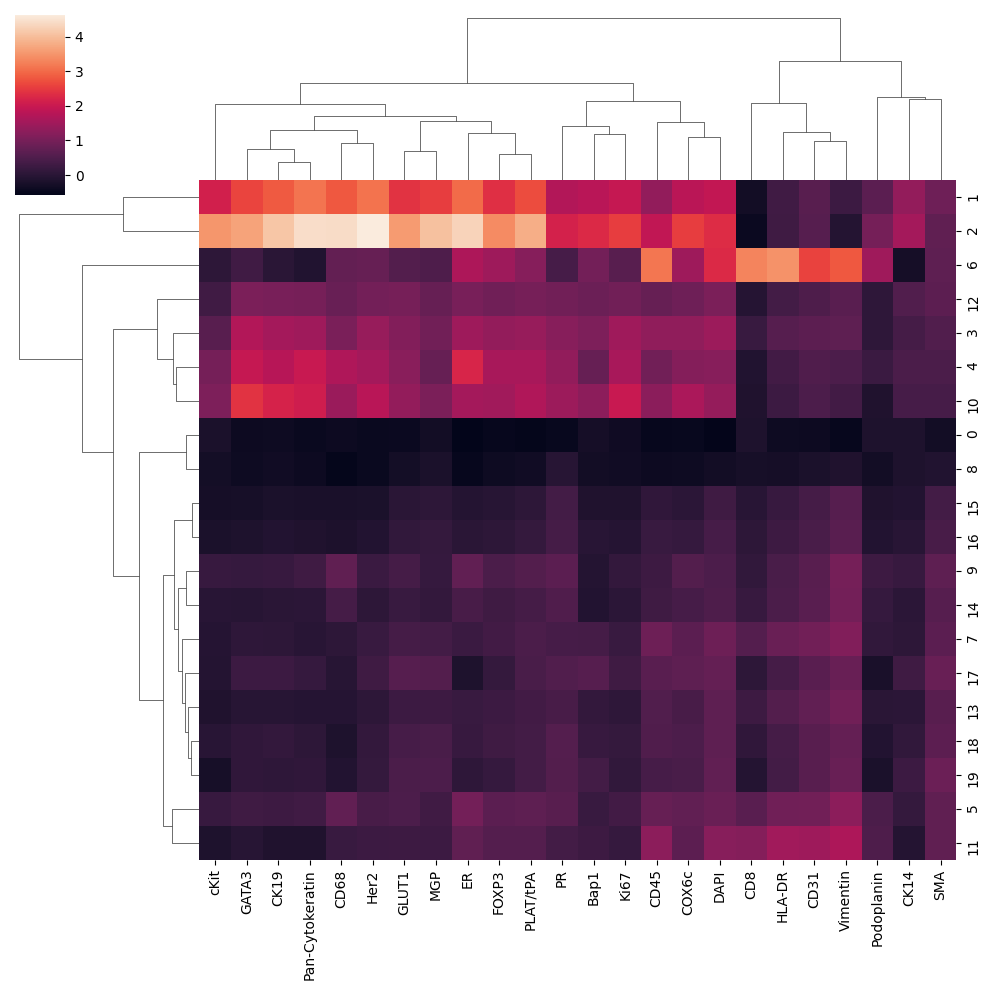

In [252]:
sns.clustermap(data=dtype_to_df['multiplex'])

In [182]:
from collections import Counter
volume = level_to_dtype_to_volume[0]['integrated']
data, labels = [], np.unique(volume)
for label in labels:
    masks = volume==label
    contacts = []
    for m, v in zip(masks, volume):
        expanded = skimage.morphology.binary_dilation(m)
        contacts += [l for l in v[expanded] if l != label]
    counts = Counter(contacts)
    data.append([counts.get(l, 0) for l in labels])
contact_df = pd.DataFrame(data=data, columns=labels, index=labels)
contact_df /= np.expand_dims(contact_df.sum(1).values, -1)
contact_df

,0,1,2,3,4,5,6,7
0,0.000000,0.186290,0.095805,0.018623,0.046186,0.076873,0.566696,0.009528
1,0.184958,0.000000,0.063565,0.028663,0.369610,0.157744,0.194680,0.000780
2,0.386797,0.275360,0.000000,0.083254,0.155046,0.050677,0.047660,0.001207
3,0.068594,0.147276,0.108944,0.000000,0.502354,0.102219,0.049092,0.021520
4,0.040232,0.415459,0.040725,0.094177,0.000000,0.258688,0.128175,0.022544
5,0.066700,0.176116,0.013903,0.024639,0.259962,0.000000,0.409579,0.049101
6,0.386199,0.173811,0.010597,0.010061,0.091754,0.250446,0.000000,0.077132
7,0.041491,0.002813,0.001406,0.020394,0.081575,0.208158,0.644163,0.000000


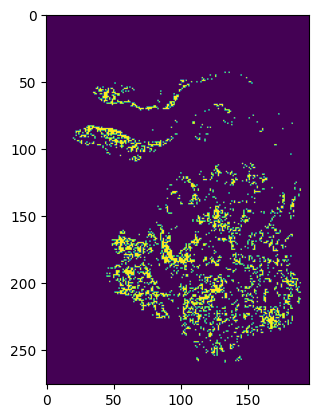

In [214]:
seed = 4
masks = level_to_dtype_to_volume[0]['integrated']==seed
m = masks[section_idx]
plt.imshow(m)

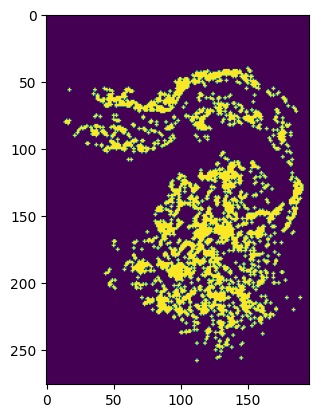

In [171]:
expanded = skimage.morphology.binary_dilation(m)

plt.imshow(expanded)

In [172]:
v = dtype_to_volume['integrated'][section_idx]
v.shape

(276, 196)

In [175]:
contacts = [l for l in v[expanded] if l != seed]
contacts

[1,
 6,
 1,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 0,
 6,
 6,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 7,
 7,
 4,
 7,
 6,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 7,
 6,
 6,
 6,
 7,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 7,
 4,
 7,
 6,
 7,
 6,
 7,
 7,
 7,
 7,
 6,
 4,
 7,
 7,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 4,
 6,
 6,
 7,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 6,
 6,
 7,
 7,
 7,
 4,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 4,
 4,
 6,
 4,
 4,
 4,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 7,
 7,
 7,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 4,
 7,
 6,
 6,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 6,
 6,
 7,
 6,


In [112]:
dtype = 'xenium'

In [114]:
volume = level_to_dtype_to_volume[2][dtype]
volume.shape

(7, 276, 196)

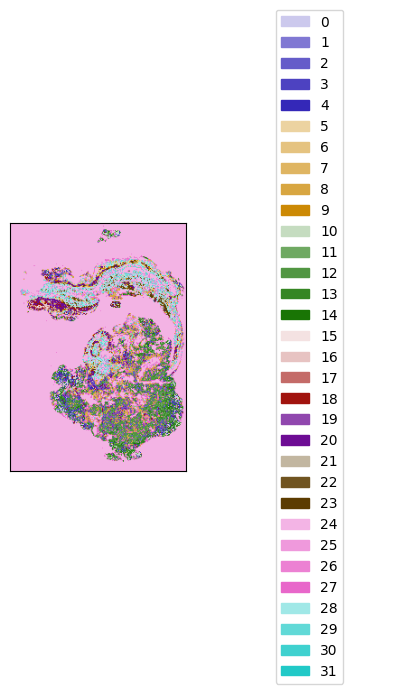

In [115]:
mushroom.display_clusters(dtype, 2, figsize=(5, 5))

In [124]:
bbox = (100, 150, 120, 170)

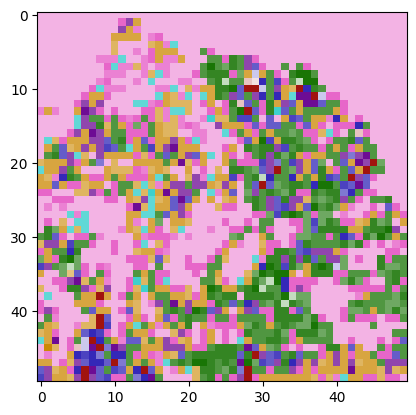

In [125]:
rgb = vis_utils.display_labeled_as_rgb(volume[2], label_to_hierarchy=outputs['dtype_to_cluster_to_agg'][dtype][2])
plt.imshow(rgb[bbox[0]:bbox[1], bbox[2]:bbox[3]])

In [104]:
level_to_dtype_to_volume[2]['integrated'].shape

(7, 276, 196)

In [110]:
# rgb = vis_utils.display_labeled_as_rgb(level_to_dtype_to_volume[2]['integrated'][2])
# plt.imshow(rgb[bbox[0]:bbox[1], bbox[2]:bbox[3]])

In [111]:
# volume[2, bbox[0]:bbox[1], bbox[2]:bbox[3]]

In [126]:
seed = 13

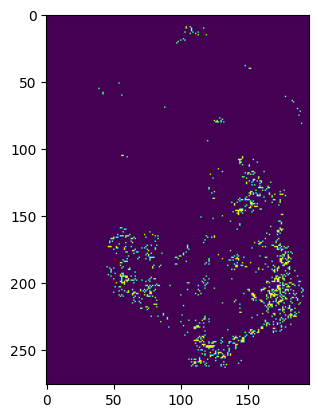

In [127]:
mask = volume==seed
plt.imshow(mask[2])

In [129]:
case_to_specific[case][dtype]

,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,ADH1C,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,0.340314,2.811056,0.690512,1.593009,2.886210,2.192092,2.194993,1.304393,1.936255,0.243409,...,0.290282,0.105298,0.380045,3.439014,3.547852,3.052231,0.203851,1.314393,2.271492,1.805595
1,0.216039,1.207221,0.699244,1.002272,1.735500,1.398614,1.534885,0.851277,1.418311,0.134232,...,0.261430,0.085185,0.217605,1.681544,1.945237,1.994886,0.163692,0.996724,1.177695,1.455745
2,0.177676,0.830765,0.724568,0.956430,1.487225,1.251245,1.404476,0.753856,1.326361,0.123549,...,0.302012,0.080100,0.176532,1.310198,1.595555,1.742008,0.136542,0.946979,0.952459,1.375541
3,0.235821,1.425171,0.674119,0.975317,1.803117,1.384973,1.509606,0.851023,1.358508,0.153790,...,0.247482,0.087227,0.221726,1.877727,2.126549,2.050485,0.162089,0.982522,1.296550,1.390561
4,0.247584,1.546272,0.869246,1.515889,2.270957,1.868923,1.981143,1.111831,1.902817,0.251361,...,0.446172,0.098691,0.299114,2.208968,2.407205,2.438592,0.192383,1.365983,1.614847,1.856268
5,0.008057,-0.421623,0.347787,1.051600,0.496949,0.239155,0.432879,0.125622,0.372788,0.398740,...,0.871969,0.000358,0.030610,0.224453,-0.141755,0.422991,0.042811,0.717737,0.113232,0.377789
6,0.067188,-0.398812,0.521439,1.299966,0.767358,0.537893,0.745243,0.280745,0.754316,0.443878,...,0.919660,0.022275,0.081384,0.355899,0.056205,0.713710,0.065376,0.966306,0.282250,0.765638
7,0.042384,-0.168170,0.326403,0.579759,0.413625,0.350612,0.501084,0.202281,0.523079,0.151064,...,0.401621,-0.008631,0.024671,0.220221,0.175658,0.503112,0.046899,0.528796,0.163710,0.501111
8,0.094954,0.220768,0.497059,0.609589,0.769433,0.682209,0.829610,0.418395,0.808108,0.096318,...,0.317125,0.047082,0.087599,0.619565,0.736601,1.029617,0.076472,0.661961,0.439633,0.817028
9,0.087332,-0.341672,0.626789,1.661750,1.011799,0.735354,0.953770,0.371531,0.952228,0.538569,...,1.112174,0.024982,0.116874,0.513066,0.140233,0.920474,0.081198,1.174579,0.420547,0.973946


In [137]:
def get_profiles(volume, seed, dist=10., n=1000):
    mask = volume==seed
    max_bounds = mask.shape
    min_bounds = (0, 0, 0)
    
    verts, faces, normals, values = skimage.measure.marching_cubes(mask)
    
    idxs = np.random.choice(np.arange(verts.shape[0]), size=n, replace=True)
    profiles = []
    for idx in idxs:
        start = verts[idx]
        stop = start + (normals[idx] * dist)
        
        if not np.count_nonzero(stop >= max_bounds) and not np.count_nonzero(stop < min_bounds):
            line = skimage.draw.line_nd(start, stop, integer=True)
            profile = volume[line]
            profile = np.pad(profile, (0, int(dist) - len(profile)))
            profiles.append(profile)
    
    return np.stack(profiles)
        

In [138]:
profiles = get_profiles(volume, seed)

In [139]:
profiles[:10]

array([[13, 19,  8,  7, 24, 24, 24, 24,  0,  0],
       [11, 11,  0, 17, 17,  0,  4, 27, 13, 13],
       [ 8,  8, 24, 24, 27, 27, 27, 12, 12, 27],
       [13, 27, 27,  4,  4,  8,  8, 14, 14, 13],
       [13, 12, 12, 12, 12,  2, 12,  8, 12,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [13, 10, 13, 14, 14, 11,  4, 27, 24, 27],
       [13,  2, 19,  8, 24,  8, 19,  2, 27, 27],
       [13,  6, 23, 24, 24, 24, 24, 24,  0,  0],
       [13, 24, 24, 24, 24, 24, 24, 24,  0,  0]])

In [143]:
exp_df = case_to_specific[case][dtype]


,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,ADH1C,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,0.340314,2.811056,0.690512,1.593009,2.886210,2.192092,2.194993,1.304393,1.936255,0.243409,...,0.290282,0.105298,0.380045,3.439014,3.547852,3.052231,0.203851,1.314393,2.271492,1.805595
1,0.216039,1.207221,0.699244,1.002272,1.735500,1.398614,1.534885,0.851277,1.418311,0.134232,...,0.261430,0.085185,0.217605,1.681544,1.945237,1.994886,0.163692,0.996724,1.177695,1.455745
2,0.177676,0.830765,0.724568,0.956430,1.487225,1.251245,1.404476,0.753856,1.326361,0.123549,...,0.302012,0.080100,0.176532,1.310198,1.595555,1.742008,0.136542,0.946979,0.952459,1.375541
3,0.235821,1.425171,0.674119,0.975317,1.803117,1.384973,1.509606,0.851023,1.358508,0.153790,...,0.247482,0.087227,0.221726,1.877727,2.126549,2.050485,0.162089,0.982522,1.296550,1.390561
4,0.247584,1.546272,0.869246,1.515889,2.270957,1.868923,1.981143,1.111831,1.902817,0.251361,...,0.446172,0.098691,0.299114,2.208968,2.407205,2.438592,0.192383,1.365983,1.614847,1.856268
5,0.008057,-0.421623,0.347787,1.051600,0.496949,0.239155,0.432879,0.125622,0.372788,0.398740,...,0.871969,0.000358,0.030610,0.224453,-0.141755,0.422991,0.042811,0.717737,0.113232,0.377789
6,0.067188,-0.398812,0.521439,1.299966,0.767358,0.537893,0.745243,0.280745,0.754316,0.443878,...,0.919660,0.022275,0.081384,0.355899,0.056205,0.713710,0.065376,0.966306,0.282250,0.765638
7,0.042384,-0.168170,0.326403,0.579759,0.413625,0.350612,0.501084,0.202281,0.523079,0.151064,...,0.401621,-0.008631,0.024671,0.220221,0.175658,0.503112,0.046899,0.528796,0.163710,0.501111
8,0.094954,0.220768,0.497059,0.609589,0.769433,0.682209,0.829610,0.418395,0.808108,0.096318,...,0.317125,0.047082,0.087599,0.619565,0.736601,1.029617,0.076472,0.661961,0.439633,0.817028
9,0.087332,-0.341672,0.626789,1.661750,1.011799,0.735354,0.953770,0.371531,0.952228,0.538569,...,1.112174,0.024982,0.116874,0.513066,0.140233,0.920474,0.081198,1.174579,0.420547,0.973946


In [140]:
n_bins = max([len(x) for x in profiles])
counts = pd.DataFrame(data=np.zeros((n_bins, len(np.unique(volume))), dtype=int))
for i in range(n_bins):
    for profile in profiles:
        if i < len(profile):
            counts.iloc[i, profile[i]] += 1
counts /= np.expand_dims(counts.sum(1).values, -1)
counts

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.019153,0.009073,0.020161,0.029234,0.019153,0.000000,0.000000,0.001008,0.026210,0.000000,...,0.000000,0.000000,0.022177,0.000000,0.001008,0.043347,0.000000,0.000000,0.000000,0.0
1,0.046371,0.023185,0.058468,0.061492,0.050403,0.000000,0.001008,0.004032,0.057460,0.000000,...,0.000000,0.001008,0.065524,0.000000,0.000000,0.086694,0.000000,0.001008,0.001008,0.0
2,0.035282,0.010081,0.049395,0.037298,0.021169,0.000000,0.003024,0.015121,0.053427,0.000000,...,0.000000,0.001008,0.117944,0.002016,0.007056,0.100806,0.002016,0.002016,0.000000,0.0
3,0.028226,0.010081,0.047379,0.039315,0.024194,0.001008,0.003024,0.014113,0.057460,0.000000,...,0.000000,0.002016,0.146169,0.001008,0.013105,0.115927,0.001008,0.002016,0.001008,0.0
4,0.027218,0.011089,0.053427,0.024194,0.036290,0.001008,0.000000,0.012097,0.049395,0.000000,...,0.000000,0.000000,0.163306,0.002016,0.014113,0.112903,0.003024,0.007056,0.000000,0.0
5,0.025202,0.010081,0.051411,0.033266,0.028226,0.000000,0.000000,0.007056,0.069556,0.001008,...,0.000000,0.000000,0.190524,0.000000,0.014113,0.110887,0.006048,0.006048,0.000000,0.0
6,0.023185,0.015121,0.046371,0.034274,0.021169,0.001008,0.000000,0.008065,0.072581,0.001008,...,0.000000,0.004032,0.211694,0.003024,0.009073,0.094758,0.002016,0.010081,0.000000,0.0
7,0.028226,0.018145,0.053427,0.035282,0.021169,0.001008,0.003024,0.014113,0.061492,0.000000,...,0.001008,0.003024,0.245968,0.002016,0.014113,0.105847,0.001008,0.007056,0.000000,0.0
8,0.117944,0.008065,0.042339,0.027218,0.014113,0.002016,0.000000,0.012097,0.060484,0.000000,...,0.001008,0.001008,0.233871,0.000000,0.014113,0.105847,0.004032,0.006048,0.000000,0.0
9,0.149194,0.006048,0.036290,0.025202,0.013105,0.003024,0.000000,0.017137,0.069556,0.000000,...,0.001008,0.000000,0.232863,0.000000,0.012097,0.080645,0.001008,0.008065,0.000000,0.0


In [141]:
counts

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.019153,0.009073,0.020161,0.029234,0.019153,0.000000,0.000000,0.001008,0.026210,0.000000,...,0.000000,0.000000,0.022177,0.000000,0.001008,0.043347,0.000000,0.000000,0.000000,0.0
1,0.046371,0.023185,0.058468,0.061492,0.050403,0.000000,0.001008,0.004032,0.057460,0.000000,...,0.000000,0.001008,0.065524,0.000000,0.000000,0.086694,0.000000,0.001008,0.001008,0.0
2,0.035282,0.010081,0.049395,0.037298,0.021169,0.000000,0.003024,0.015121,0.053427,0.000000,...,0.000000,0.001008,0.117944,0.002016,0.007056,0.100806,0.002016,0.002016,0.000000,0.0
3,0.028226,0.010081,0.047379,0.039315,0.024194,0.001008,0.003024,0.014113,0.057460,0.000000,...,0.000000,0.002016,0.146169,0.001008,0.013105,0.115927,0.001008,0.002016,0.001008,0.0
4,0.027218,0.011089,0.053427,0.024194,0.036290,0.001008,0.000000,0.012097,0.049395,0.000000,...,0.000000,0.000000,0.163306,0.002016,0.014113,0.112903,0.003024,0.007056,0.000000,0.0
5,0.025202,0.010081,0.051411,0.033266,0.028226,0.000000,0.000000,0.007056,0.069556,0.001008,...,0.000000,0.000000,0.190524,0.000000,0.014113,0.110887,0.006048,0.006048,0.000000,0.0
6,0.023185,0.015121,0.046371,0.034274,0.021169,0.001008,0.000000,0.008065,0.072581,0.001008,...,0.000000,0.004032,0.211694,0.003024,0.009073,0.094758,0.002016,0.010081,0.000000,0.0
7,0.028226,0.018145,0.053427,0.035282,0.021169,0.001008,0.003024,0.014113,0.061492,0.000000,...,0.001008,0.003024,0.245968,0.002016,0.014113,0.105847,0.001008,0.007056,0.000000,0.0
8,0.117944,0.008065,0.042339,0.027218,0.014113,0.002016,0.000000,0.012097,0.060484,0.000000,...,0.001008,0.001008,0.233871,0.000000,0.014113,0.105847,0.004032,0.006048,0.000000,0.0
9,0.149194,0.006048,0.036290,0.025202,0.013105,0.003024,0.000000,0.017137,0.069556,0.000000,...,0.001008,0.000000,0.232863,0.000000,0.012097,0.080645,0.001008,0.008065,0.000000,0.0


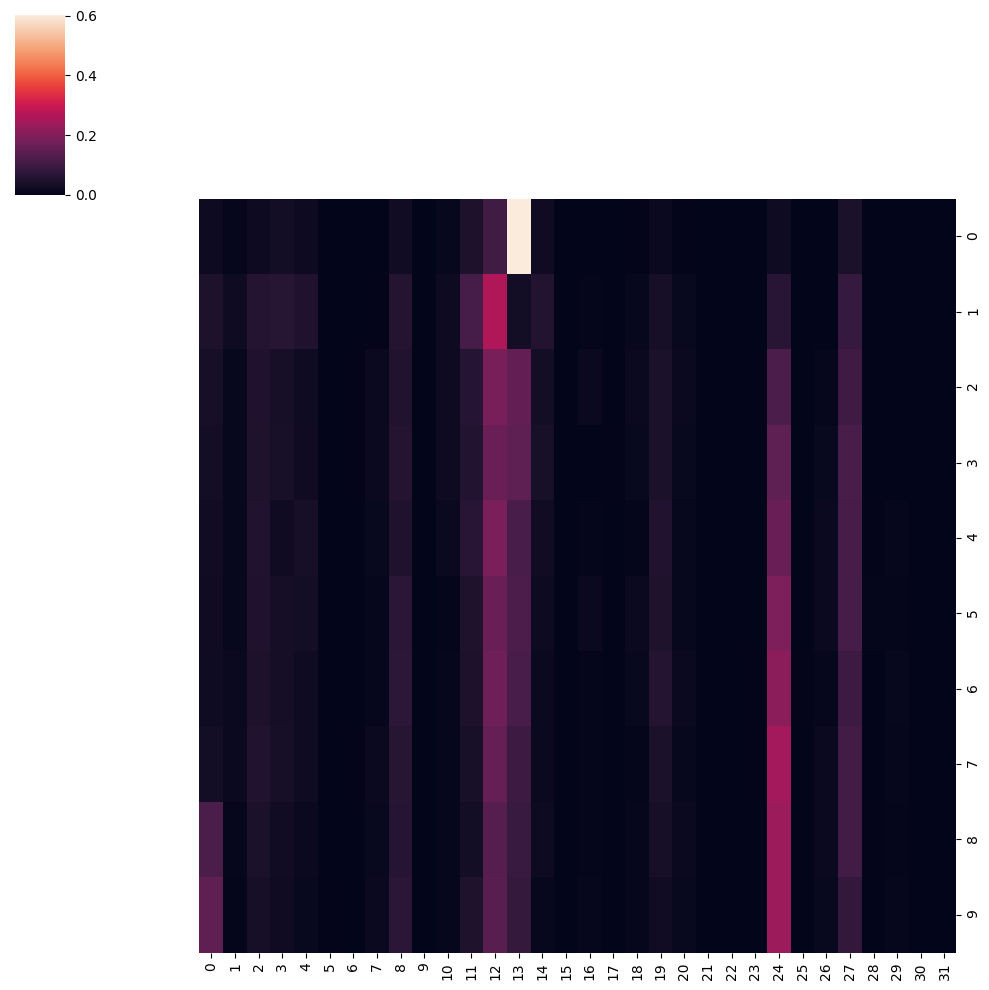

In [142]:
sns.clustermap(counts, row_cluster=False, col_cluster=False)

In [38]:
import skimage

In [39]:
verts, faces, normals, values = skimage.measure.marching_cubes(mask)

In [41]:
verts.shape, faces.shape, normals.shape

((22848, 3), (39168, 3), (22848, 3))

In [45]:
normals[:2], verts[:2]

(array([[ 0.        , -0.9486833 , -0.31622776],
        [ 0.        ,  0.        , -1.        ]], dtype=float32),
 array([[  0. ,  41.5, 117. ],
        [  1. ,  42. , 116.5]], dtype=float32))

In [47]:
start = verts[0]
stop = verts[0] + (normals[0] * 10)
line = skimage.draw.line_nd(start, stop, integer=True)
print(start, stop)

[  0.   41.5 117. ] [  0.       32.01317 113.83772]


In [48]:
line

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([42, 41, 40, 39, 38, 37, 36, 35, 34, 33]),
 array([117, 117, 116, 116, 116, 115, 115, 115, 114, 114]))

In [49]:
volume[line]

array([8, 0, 0, 1, 1, 1, 1, 0, 2, 2])

In [38]:
gene_sets = json.load(open(os.path.join(project_dir, 'analysis', 'gene_sets', 'c4.3ca.v2023.2.Hs.json')))
gene_sets.keys()

dict_keys(['GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_8_PROTEASOMAL_DEGRADATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2', 'GAVISH_3CA_MALIGNANT_ME

In [39]:
next(iter(gene_sets.values()))

{'collection': 'C4:3CA',
 'systematicName': 'M46567',
 'pmid': '37258682',
 'exactSource': '3CA Download meta_programs_2023-07-13: Malignant. 1  Cell Cycle - G2/M',
 'externalDetailsURL': 'https://www.weizmann.ac.il/sites/3CA/',
 'msigdbURL': 'https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M',
 'geneSymbols': ['ARL6IP1',
  'ASPM',
  'AURKA',
  'AURKB',
  'BIRC5',
  'CCNA2',
  'CCNB1',
  'CCNB2',
  'CDC20',
  'CDCA3',
  'CDCA8',
  'CDK1',
  'CDKN3',
  'CENPA',
  'CENPE',
  'CENPF',
  'CENPW',
  'CKAP2',
  'CKS1B',
  'CKS2',
  'DEPDC1',
  'DLGAP5',
  'ECT2',
  'GTSE1',
  'H4C3',
  'HMGB2',
  'HMMR',
  'KIF20B',
  'KIF23',
  'KIF2C',
  'KNSTRN',
  'KPNA2',
  'MAD2L1',
  'MKI67',
  'NUF2',
  'NUSAP1',
  'PBK',
  'PLK1',
  'PRC1',
  'PTTG1',
  'SMC4',
  'STMN1',
  'TACC3',
  'TOP2A',
  'TPX2',
  'TUBA1B',
  'UBE2C',
  'UBE2S',
  'UBE2T',
  'ZWINT'],
 'filteredBySimilarity': [],
 'externalNamesForSimilarTerms': []}

In [246]:
df = case_to_integrated['HT397B1']['visium']
[c for c in df if 'HLA' in c]

['HHLA3',
 'HLA-A',
 'HLA-C',
 'HLA-DMA',
 'HLA-DMB',
 'HLA-DOA',
 'HLA-DPA1',
 'HLA-DPB1',
 'HLA-DQA1',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DRB5',
 'HLA-E',
 'HLA-F']

In [40]:
volume_dtypes = ['xenium', 'visium', 'integrated']
quant_dtypes = ['xenium', 'visium']

In [286]:
# macro_gene_sets = {
#     'epithelial': [
#         'KRT18', 'EPCAM', 'LRP2', 'CA9', 'KRT10',
#  'KRT14',
#  'KRT15',
#  'KRT18',
#  'KRT23',
#  'KRT5',
#  'KRT7',
#  'KRT8',
#  'KRT80',
#     ],
#     'immune': [
# #         'PTPRC', 'CD3D', 'IL7R', 'CD68', 'MS4A1', 'GZMK', 'LYZ', 'ITGAM'
#         'PTPRC', 'HLA-A',
#  'HLA-C',
#  'HLA-DMA',
#  'HLA-DMB',
#  'HLA-DOA',
#  'HLA-DPA1',
#  'HLA-DPB1',
#  'HLA-DQA1',
#  'HLA-DRA',
#  'HLA-DRB1',
#  'HLA-DRB5',
#  'HLA-E',
#  'HLA-F'
#     ],
#     'stroma': [
# #         'ACTA2', 'FAP',
#  'COL11A1',
#  'COL12A1',
#  'COL14A1',
#  'COL15A1',
#  'COL16A1',
#  'COL18A1',
#  'COL1A1',
#  'COL1A2',
#  'COL27A1',
#  'COL3A1',
#  'COL4A1',
#  'COL4A2',
#  'COL4A5',
#  'COL5A1',
#  'COL5A2',
#  'COL5A3',
#  'COL6A1',
#  'COL6A2',
#  'COL6A3',
#  'COL7A1',
#  'COL8A1',
#  'COL8A2',
#  'COL9A2'
#     ]
# }

In [287]:
# data = []

# for case in case_order:
#     print(case)
#     disease = case_to_disease[case]
#     dtype_to_specific = case_to_specific[case]
#     dtype_to_integrated = case_to_integrated[case]
    
#     outputs = pickle.load(open(
#         os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
    
#     for volume_dtype in volume_dtypes:
#         if volume_dtype in outputs['dtype_to_volume']:
#             volume = outputs['dtype_to_volume'][volume_dtype]
#             labels, counts = np.unique(volume, return_counts=True)
#             total = counts.sum()
#             label_to_count = {l:c for l, c in zip(labels, counts)}
        
#         if volume_dtype == 'integrated':
#             for quant_dtype in quant_dtypes:
#                 if quant_dtype in dtype_to_integrated:
#                     df = dtype_to_integrated[quant_dtype]
#                     for name, gs in macro_gene_sets.items():
#                         genes = [g for g in gs if g in df.columns]
#                         print(quant_dtype, genes)
#                         if genes:
#                             nbhd_scores = df[genes].values.mean(1)
#                             for nbhd, score in zip(df.index.to_list(), nbhd_scores):
#                                 area = label_to_count[nbhd]
#                                 data.append([case, disease, quant_dtype, 'integrated', name, nbhd, area, area / total, score])
#         else:
#             if volume_dtype in dtype_to_specific:
#                 df = dtype_to_specific[volume_dtype]
#                 for name, gs in macro_gene_sets.items():
#                     genes = [g for g in gs if g in df.columns]
#                     if genes:
#                         nbhd_scores = df[genes].values.mean(1)
#                         for nbhd, score in zip(df.index.to_list(), nbhd_scores):
#                             area = label_to_count[nbhd]
#                             data.append([case, disease, volume_dtype, 'specific', name, nbhd, area, area / total, score])
# score_df = pd.DataFrame(data=data, columns=['case', 'disease', 'dtype', 'type', 'gene_set', 'nbhd', 'area', 'area_frac', 'score'])
# score_df

In [288]:
# df = score_df.copy()
# df = df[df['type']=='integrated']
# df = df.groupby(['case', 'disease', 'dtype', 'type', 'nbhd', 'gene_set']).mean()
# df = df.reset_index()
# df = df.pivot(columns='gene_set', index=['case', 'disease', 'dtype', 'type', 'nbhd'])
# df.columns = ['_'.join(col) for col in df.columns]
# # df -= df.values.min(0)
# # df /= df.values.std(0)
# df = df.reset_index()
# df

In [289]:
data = []

for case in case_order:
    print(case)
    disease = case_to_disease[case]
    dtype_to_specific = case_to_specific[case]
    dtype_to_integrated = case_to_integrated[case]
    
    outputs = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
    
    for volume_dtype in volume_dtypes:
        if volume_dtype in outputs['dtype_to_volume']:
            volume = outputs['dtype_to_volume'][volume_dtype]
            labels, counts = np.unique(volume, return_counts=True)
            total = counts.sum()
            label_to_count = {l:c for l, c in zip(labels, counts)}
        
        if volume_dtype == 'integrated':
            for quant_dtype in quant_dtypes:
                if quant_dtype in dtype_to_integrated:
                    df = dtype_to_integrated[quant_dtype]
                    for name, gs in gene_sets.items():
                        genes = [g for g in gs['geneSymbols'] if g in df.columns]
                        if genes:
                            nbhd_scores = df[genes].values.mean(1)
                            for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                                area = label_to_count[nbhd]
                                data.append([case, disease, quant_dtype, 'integrated', name, nbhd, area, area / total, score])
        else:
            if volume_dtype in dtype_to_specific:
                df = dtype_to_specific[volume_dtype]
                for name, gs in gene_sets.items():
                    genes = [g for g in gs['geneSymbols'] if g in df.columns]
                    if genes:
                        nbhd_scores = df[genes].values.mean(1)
                        for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                            area = label_to_count[nbhd]
                            data.append([case, disease, volume_dtype, 'specific', name, nbhd, area, area / total, score])
score_df = pd.DataFrame(data=data, columns=['case', 'disease', 'dtype', 'type', 'gene_set', 'nbhd', 'area', 'area_frac', 'score'])
score_df

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


,case,disease,dtype,type,gene_set,nbhd,area,area_frac,score
0,HT339B2-H1,BRCA,visium,specific,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,0,282,0.008092,-0.114431
1,HT339B2-H1,BRCA,visium,specific,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,1,86,0.002468,2.781914
2,HT339B2-H1,BRCA,visium,specific,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,2,464,0.013315,3.208806
3,HT339B2-H1,BRCA,visium,specific,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,3,3186,0.091426,0.795420
4,HT339B2-H1,BRCA,visium,specific,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,4,24,0.000689,5.073034
...,...,...,...,...,...,...,...,...,...
113346,S18-5591-C8,PKD,xenium,integrated,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,52,298,0.000332,0.173978
113347,S18-5591-C8,PKD,xenium,integrated,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,53,227,0.000253,0.408222
113348,S18-5591-C8,PKD,xenium,integrated,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,54,407483,0.454067,-0.294549
113349,S18-5591-C8,PKD,xenium,integrated,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,55,110,0.000123,0.418733


In [282]:
# def get_macro(name):
#     if 'MALIGNANT_METAPROGRAM' in name or 'METAPROGRAM_EPITHELIAL' in name:
#         return 'epithelial'
    
#     if 'METAPROGRAM_MACROPHAGES' in name or 'METAPROGRAM_CD4_T' in name or 'METAPROGRAM_CD8_T' in name or 'METAPROGRAM_B_CELLS' in name:
#         return 'immune'
    
#     if 'METAPROGRAM_FIBROBLASTS' in name or 'METAPROGRAM_ENDOTHELIAL' in name:
#         return 'stroma'

# score_df['macro_gene_set'] = [get_macro(x) for x in score_df['gene_set']]
# score_df

In [292]:
df = score_df.copy()
df = df.groupby(['case', 'disease', 'dtype', 'type', 'nbhd', 'gene_set']).mean()
df = df.reset_index()
df = df.pivot(columns='gene_set', index=['case', 'disease', 'dtype', 'type', 'nbhd', 'area', 'area_frac'])
df.columns = ['_'.join(col) for col in df.columns]
# df = df.reset_index()
df

score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION  \
case      disease dtype  type       nbhd area     area_frac                                                                 
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.239158              
                                    1    9866.0   0.026054                                            0.510483              
                                    2    4832.0   0.012760                                            0.487860              
                                    3    29469.0  0.077822                                           -0.339523              
                                    4    6072.0   0.016035                                           -0.282876              
...                                                                                                        ...              
S18-9906  PKD     xenium specific   31   233.0    0.000239                                           -0.322768              
                                    32   7.0      0.000007                                           -0.350046              
                                    33   12480.0  0.012783                                           -0.418584              
                                    34   270.0    0.000277                                           -0.446139              
                                    35   1648.0   0.001688                                           -0.403232              

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION  \
case      disease dtype  type       nbhd area     area_frac                                                                     
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.307964                  
                                    1    9866.0   0.026054                                            1.141471                  
                                    2    4832.0   0.012760                                            0.511324                  
                                    3    29469.0  0.077822                                           -0.394505                  
                                    4    6072.0   0.016035                                           -0.020021                  
...                                                                                                        ...                  
S18-9906  PKD     xenium specific   31   233.0    0.000239                                            0.241426                  
                                    32   7.0      0.000007                                            0.289010                  
                                    33   12480.0  0.012783                                            0.325174                  
                                    34   270.0    0.000277                                            0.458321                  
                                    35   1648.0   0.001688                                            0.457868                  

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
case      disease dtype  type       nbhd area     area_frac                                                    
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                         -0.293574   
                                    1    9866.0   0.026054                                          2.437954   
                                    2    4832.0   0.012760                                          0.336667   
                                    3    29469.0  0.077822                                         -0.167454   
                                    4    6072.0   0.016035                           

In [299]:
df = df[[c for c, k in zip(df.columns, pd.isnull(df).sum(0) > 0) if not k]]
df
        

score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION  \
case      disease dtype  type       nbhd area     area_frac                                                                 
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.239158              
                                    1    9866.0   0.026054                                            0.510483              
                                    2    4832.0   0.012760                                            0.487860              
                                    3    29469.0  0.077822                                           -0.339523              
                                    4    6072.0   0.016035                                           -0.282876              
...                                                                                                        ...              
S18-9906  PKD     xenium specific   31   233.0    0.000239                                           -0.322768              
                                    32   7.0      0.000007                                           -0.350046              
                                    33   12480.0  0.012783                                           -0.418584              
                                    34   270.0    0.000277                                           -0.446139              
                                    35   1648.0   0.001688                                           -0.403232              

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION  \
case      disease dtype  type       nbhd area     area_frac                                                                     
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.307964                  
                                    1    9866.0   0.026054                                            1.141471                  
                                    2    4832.0   0.012760                                            0.511324                  
                                    3    29469.0  0.077822                                           -0.394505                  
                                    4    6072.0   0.016035                                           -0.020021                  
...                                                                                                        ...                  
S18-9906  PKD     xenium specific   31   233.0    0.000239                                            0.241426                  
                                    32   7.0      0.000007                                            0.289010                  
                                    33   12480.0  0.012783                                            0.325174                  
                                    34   270.0    0.000277                                            0.458321                  
                                    35   1648.0   0.001688                                            0.457868                  

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
case      disease dtype  type       nbhd area     area_frac                                                    
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                         -0.293574   
                                    1    9866.0   0.026054                                          2.437954   
                                    2    4832.0   0.012760                                          0.336667   
                                    3    29469.0  0.077822                                         -0.167454   
                                    4    6072.0   0.016035                           

In [312]:
diseases = sorted(set(case_to_disease.values()))
colors = [sns.color_palette()[diseases.index(z)] for z in df.reset_index()['disease']]

In [315]:
colors = [sns.color_palette('tab20')[case_order.index(z)] for z in df.reset_index()['case']]

In [311]:
sorted(set(case_to_disease.values()))

['BRCA', 'CCRCC', 'CRC', 'PDAC', 'PKD']

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



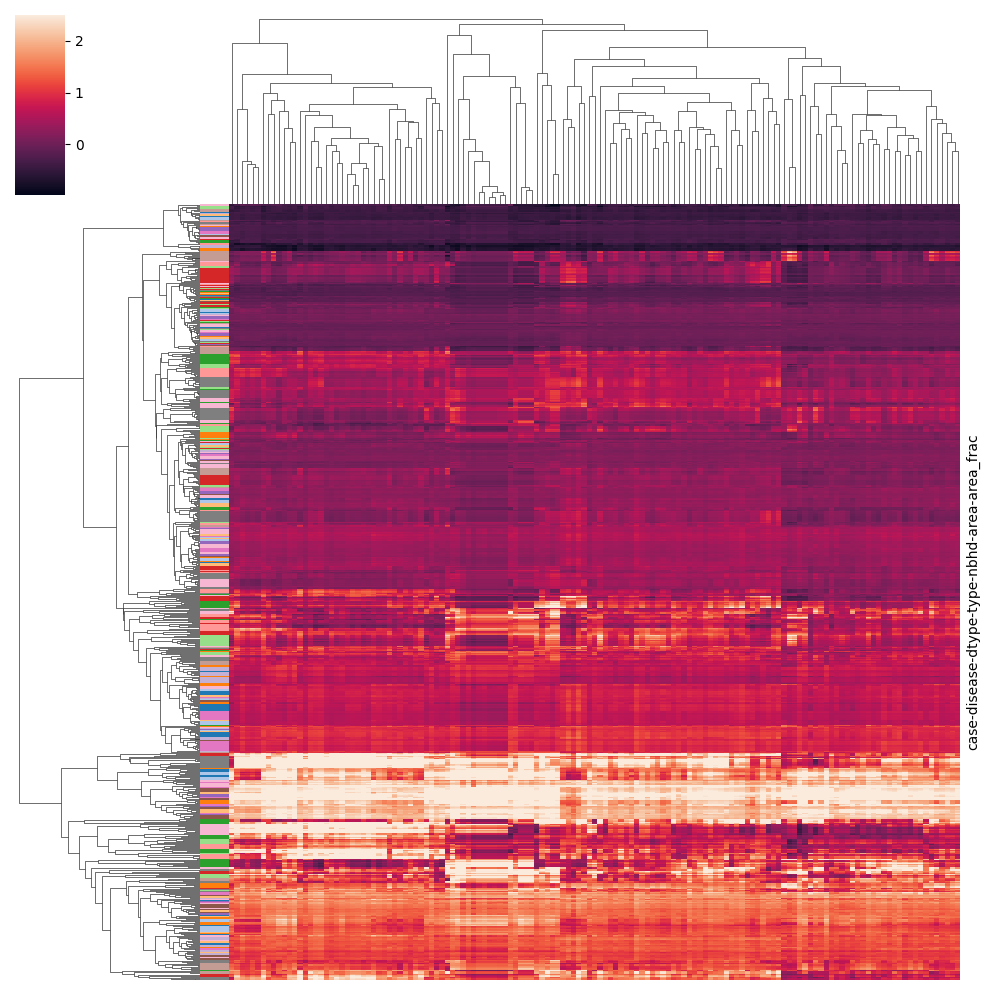

In [318]:
x = df.copy()
x[x>2.5] = 2.5
sns.clustermap(x, xticklabels=[], yticklabels=[], row_colors=colors)

In [322]:
x.reset_index()['case']=='C3L-00982'

0       True
1       True
2       True
3       True
4       True
       ...  
774    False
775    False
776    False
777    False
778    False
Name: case, Length: 779, dtype: bool

In [323]:
x

score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION  \
case      disease dtype  type       nbhd area     area_frac                                                                 
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.239158              
                                    1    9866.0   0.026054                                            0.510483              
                                    2    4832.0   0.012760                                            0.487860              
                                    3    29469.0  0.077822                                           -0.339523              
                                    4    6072.0   0.016035                                           -0.282876              
...                                                                                                        ...              
S18-9906  PKD     xenium specific   31   233.0    0.000239                                           -0.322768              
                                    32   7.0      0.000007                                           -0.350046              
                                    33   12480.0  0.012783                                           -0.418584              
                                    34   270.0    0.000277                                           -0.446139              
                                    35   1648.0   0.001688                                           -0.403232              

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION  \
case      disease dtype  type       nbhd area     area_frac                                                                     
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.307964                  
                                    1    9866.0   0.026054                                            1.141471                  
                                    2    4832.0   0.012760                                            0.511324                  
                                    3    29469.0  0.077822                                           -0.394505                  
                                    4    6072.0   0.016035                                           -0.020021                  
...                                                                                                        ...                  
S18-9906  PKD     xenium specific   31   233.0    0.000239                                            0.241426                  
                                    32   7.0      0.000007                                            0.289010                  
                                    33   12480.0  0.012783                                            0.325174                  
                                    34   270.0    0.000277                                            0.458321                  
                                    35   1648.0   0.001688                                            0.457868                  

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
case      disease dtype  type       nbhd area     area_frac                                                    
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                         -0.293574   
                                    1    9866.0   0.026054                                          2.437954   
                                    2    4832.0   0.012760                                          0.336667   
                                    3    29469.0  0.077822                                         -0.167454   
                                    4    6072.0   0.016035                           

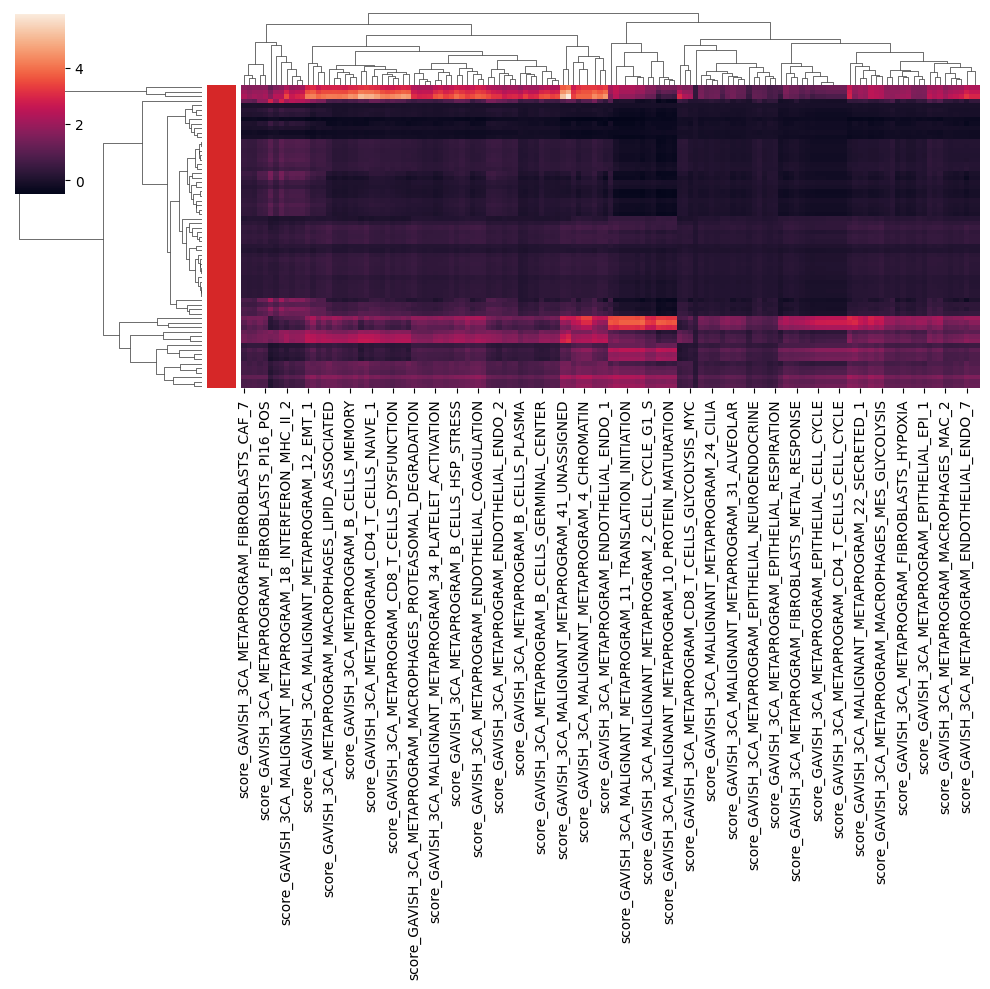

In [325]:
x = df.copy()
# x[x>2.5] = 2.5
x.index = np.arange(x.shape[0])
x = x[df.reset_index()['case']=='C3L-00982']
sns.clustermap(x, yticklabels=[], row_colors=colors)

In [328]:
x

,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2,score_GAVISH_3CA_MALIGNANT_METAPROGRAM_19_EPITHELIAL_SENESCENCE,...,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_INTERFERON,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_LIPID_ASSOCIATED,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_MAC_1,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_MAC_2,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_MAC_3,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_MES_GLYCOLYSIS,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_MONOCYTE_SECRETED,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_PROTEASOMAL_DEGRADATION,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_RESPIRATION,score_GAVISH_3CA_METAPROGRAM_MACROPHAGES_STRESS_HSP
0,-0.239158,-0.307964,-0.293574,-0.224311,-0.260283,-0.199726,-0.249289,-0.218596,-0.222233,-0.143760,...,-0.185589,-0.252584,-0.187021,-0.175266,-0.257498,-0.267438,-0.195723,-0.226223,-0.203548,-0.320792
1,0.510483,1.141471,2.437954,1.491464,1.084085,1.250129,2.162171,1.477216,2.066511,0.506597,...,1.237113,2.131281,1.770907,1.132147,2.417658,1.369106,1.515801,1.629750,1.103305,2.374171
2,0.487860,0.511324,0.336667,0.324218,0.494639,0.248628,0.327871,0.311403,0.215861,0.260899,...,0.261785,0.419693,0.239218,0.284864,0.344500,0.486097,0.301386,0.393167,0.324851,0.385807
3,-0.339523,-0.394505,-0.167454,-0.187284,-0.284437,-0.134436,-0.159600,-0.221469,-0.073385,-0.157019,...,-0.189182,-0.180915,-0.141822,-0.166493,-0.191401,-0.271719,-0.176060,-0.181867,-0.222545,-0.290294
4,-0.282876,-0.020021,1.456972,0.623151,0.243042,0.794284,1.060863,0.280434,1.464295,0.087465,...,0.240223,0.631653,0.462282,0.273492,0.688332,0.308266,0.425244,0.435171,0.128878,0.944531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.407195,0.385251,0.104065,0.166157,0.378365,0.138192,0.105928,0.143258,0.037550,0.202000,...,0.132533,0.117705,0.010945,0.137585,0.024252,0.309040,0.125846,0.152554,0.197289,0.169485
63,-0.394369,-0.351457,0.546101,0.135729,-0.096381,0.299541,0.336423,-0.097580,0.655465,-0.062826,...,-0.078997,0.083027,0.027371,-0.032379,0.088391,-0.084586,0.000926,0.014465,-0.158748,0.148403
64,-0.318562,-0.331904,0.161047,-0.011307,-0.162868,0.053605,0.106593,-0.088231,0.243213,-0.091290,...,-0.087249,0.104936,0.043580,-0.041618,0.082646,-0.108538,-0.021724,0.042963,-0.123170,-0.093143
65,-0.014935,-0.004711,0.165979,0.097979,0.068373,0.089721,0.165971,0.082883,0.171475,0.033821,...,0.057533,0.253645,0.144775,0.091523,0.208598,0.115490,0.114862,0.201578,0.061932,0.057021


In [326]:
mushroom = Mushroom.from_config('/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res')

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['C3L-00982-U5', 'C3L-00982-U5_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U5


0.02


INFO:root:generating image data for section C3L-00982-U5_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U5', 'he'), ('C3L-00982-U5_dup', 'he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpcx3aii3j
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpcx3aii3j/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


he torch.Size([3, 274, 193])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/he_chkpts/last-v3.ckpt
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 32 channels
INFO:root:3 sections detected: ['C3L-00982-U1', 'C3L-00982-U4', 'C3L-00982-U7']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U1


0.02


INFO:root:generating image data for section C3L-00982-U4
INFO:root:generating image data for section C3L-00982-U7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('C3L-00982-U1', 'multiplex'), ('C3L-00982-U4', 'multiplex'), ('C3L-00982-U7', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/multiplex_chkpts/last-v3.ckpt


multiplex torch.Size([32, 274, 193])


INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-00982-U2', 'C3L-00982-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U2
INFO:root:generating image data for section C3L-00982-U2_dup


xenium torch.Size([477, 275, 194])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U2', 'xenium'), ('C3L-00982-U2_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/xenium_chkpts/last-v2.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoa

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

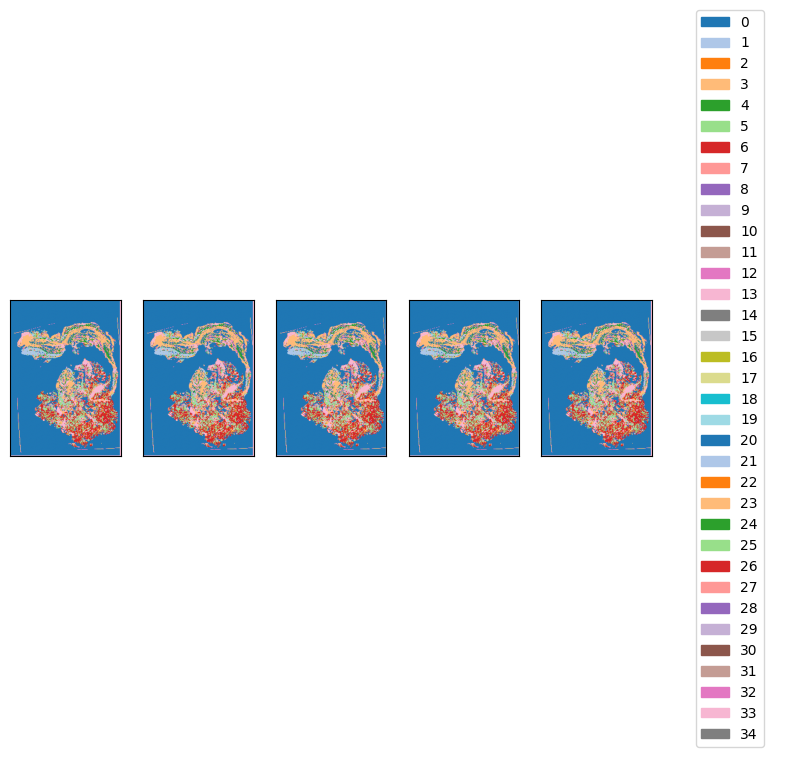

In [327]:
mushroom.display_clusters(dtype='integrated')

In [330]:
dtype_to_df = mushroom.calculate_cluster_intensities(case_to_integrated['C3L-00982'])
dtype_to_df.keys()

dict_keys(['he', 'multiplex', 'xenium'])

In [333]:
# dtype_to_df['xenium']

In [337]:
df = dtype_to_df['xenium']
data = []
idxs = []
for name, gs in gene_sets.items():
    genes = [g for g in gs['geneSymbols'] if g in df.columns]
    if genes:
        nbhd_scores = df[genes].values.mean(1)
        data.append(nbhd_scores)
        idxs.append(name)
df = pd.DataFrame(data=data, index=idxs, columns=df.index.to_list()).T
df


,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M,GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S,GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH,GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN,GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS,GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA,GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO,GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE,GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION,GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION,...,GAVISH_3CA_METAPROGRAM_B_CELLS_MHC_II,GAVISH_3CA_METAPROGRAM_B_CELLS_CELL_CYCLE,GAVISH_3CA_METAPROGRAM_B_CELLS_STRESS,GAVISH_3CA_METAPROGRAM_B_CELLS_MEMORY,GAVISH_3CA_METAPROGRAM_B_CELLS_METABOLISM_MYC,GAVISH_3CA_METAPROGRAM_B_CELLS_GERMINAL_CENTER,GAVISH_3CA_METAPROGRAM_B_CELLS_INTERFERON,GAVISH_3CA_METAPROGRAM_B_CELLS_PROGENITOR,GAVISH_3CA_METAPROGRAM_B_CELLS_RESPIRATION,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS
0,2.256838,2.956266,3.465729,3.330663,2.604599,3.509618,3.279279,3.020427,3.207988,3.556883,...,1.595510,2.184618,1.603773,1.659642,1.512934,1.145537,2.515942,0.713518,3.770053,1.991098
1,1.015269,1.419977,1.684487,1.775466,1.468913,1.875506,1.467987,1.536681,1.545715,1.777706,...,1.087130,1.024842,1.051346,1.207677,1.007866,0.833391,1.622804,0.574930,1.904362,1.193368
2,0.753000,1.076229,1.303412,1.377136,1.175657,1.495437,1.110264,1.200990,1.163607,1.350336,...,0.872068,0.770221,0.848438,0.999806,0.845083,0.665644,1.336407,0.461248,1.482950,0.951132
3,1.166278,1.620638,1.906549,1.872513,1.530337,2.035310,1.718492,1.698186,1.752350,1.967235,...,1.017831,1.158150,1.002212,1.126899,0.953078,0.764882,1.590910,0.513598,2.120268,1.192271
4,1.345181,1.865150,2.211693,2.400859,1.951960,2.380628,1.923866,2.086829,1.947368,2.308590,...,1.480774,1.350866,1.435760,1.555830,1.404093,1.103025,2.071203,0.763489,2.485348,1.629870
5,-0.177588,-0.172176,-0.162231,0.269826,0.340863,-0.069094,-0.307496,0.009370,-0.254594,-0.171051,...,0.327642,-0.135255,0.366196,0.334105,0.378920,0.369426,0.312590,0.211145,-0.149426,0.352139
6,-0.114611,-0.075315,-0.024967,0.519881,0.565799,0.130035,-0.231678,0.197565,-0.175123,-0.006809,...,0.583718,-0.058332,0.604406,0.603695,0.590159,0.567058,0.606839,0.362488,0.056959,0.583713
7,-0.024431,-0.001472,0.021259,0.284351,0.287315,0.196757,-0.047403,0.117782,0.036289,0.077169,...,0.300198,-0.006402,0.271578,0.363211,0.387836,0.288860,0.381149,0.169611,0.142411,0.258768
8,0.270830,0.425013,0.524873,0.687612,0.599186,0.722383,0.415341,0.524797,0.506187,0.578498,...,0.486917,0.288624,0.453955,0.610260,0.533768,0.398242,0.713774,0.264654,0.676568,0.480826
9,-0.088327,-0.028922,0.019021,0.787942,0.803456,0.207001,-0.224120,0.356208,-0.198372,0.096629,...,0.829226,-0.008739,0.863977,0.815926,0.822072,0.782072,0.801043,0.505920,0.131665,0.849550


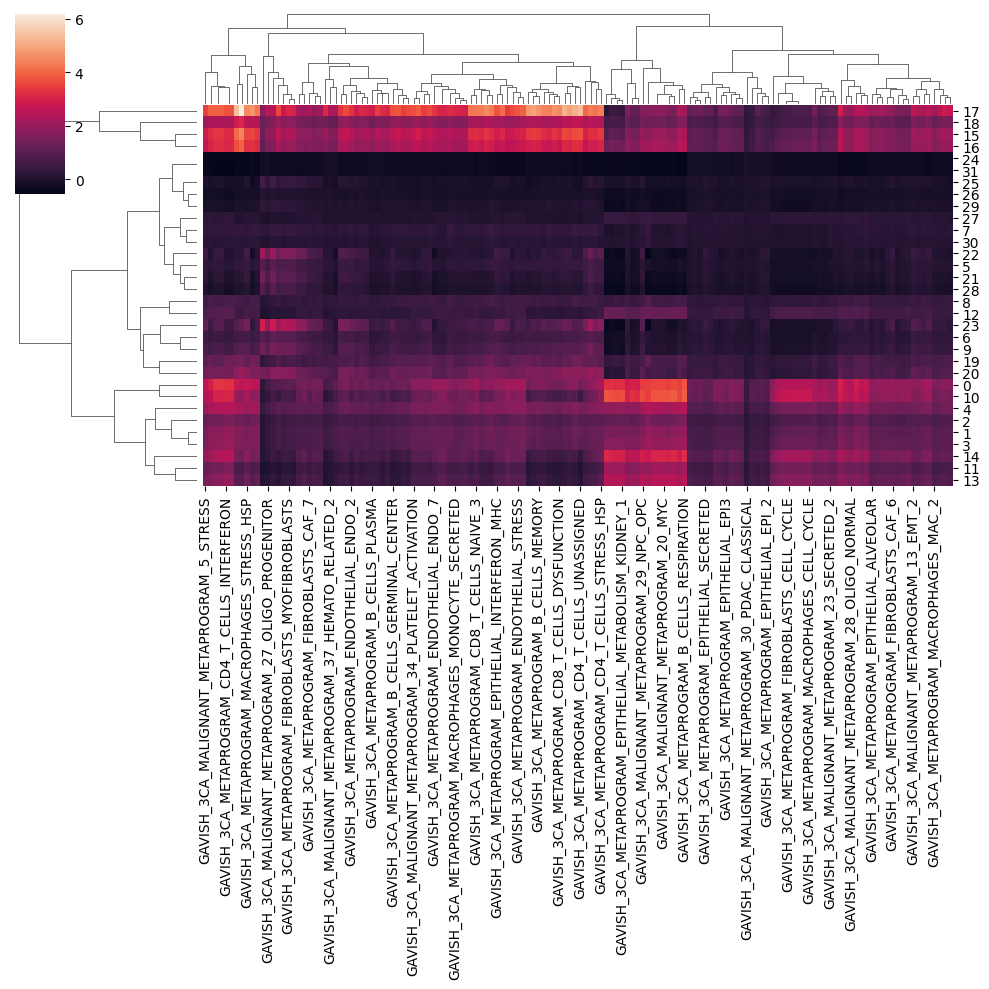

In [338]:
sns.clustermap(df)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



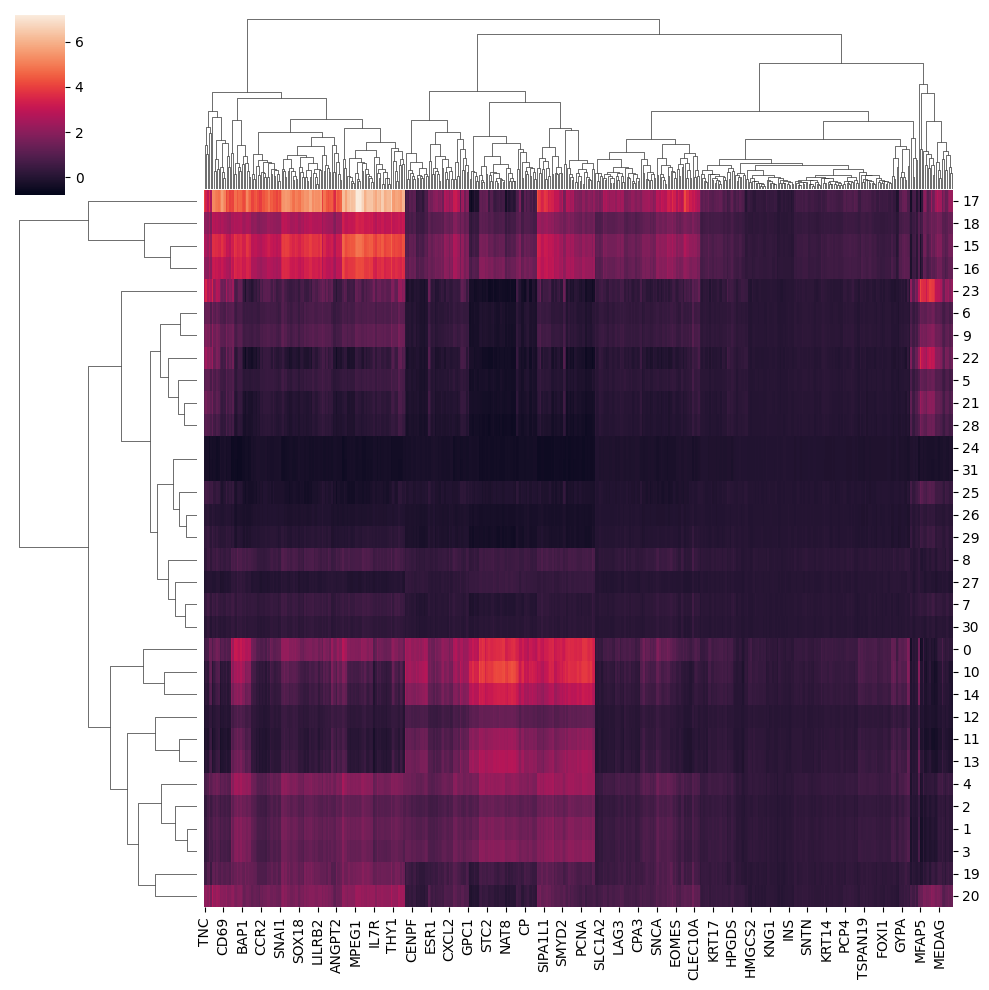

In [332]:
sns.clustermap(dtype_to_df['xenium'])

In [300]:
import umap

In [301]:
x = umap.UMAP().fit_transform(df.values)
x.shape

(779, 2)

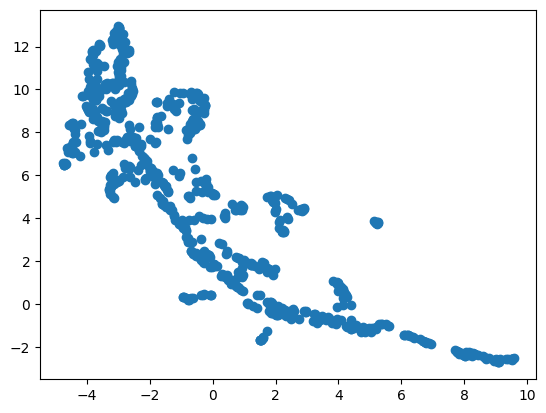

In [302]:
plt.scatter(x[:, 0], x[:, 1])

In [284]:
# sns.pairplot(data=df,
#              x_vars=['score_epithelial', 'score_stroma', 'score_immune', 'area_epithelial'],
#             y_vars=['score_epithelial', 'score_stroma', 'score_immune', 'area_epithelial'], hue='dtype')

In [285]:
fig = px.scatter_ternary(df, a="score_epithelial", b="score_immune", c="score_stroma",
                         color='disease', symbol='dtype')
fig

In [272]:
fig = px.scatter_ternary(df[df['disease']=='CCRCC'], a="score_epithelial", b="score_immune", c="score_stroma",
                         color='disease', symbol='dtype')
fig

In [276]:
fig = px.scatter_ternary(df.iloc[:1], a="score_epithelial", b="score_immune", c="score_stroma",
                         color='disease', symbol='dtype')
fig

In [275]:
df.iloc[:1]

,case,disease,dtype,type,nbhd,area_epithelial,area_immune,area_stroma,area_frac_epithelial,area_frac_immune,area_frac_stroma,score_epithelial,score_immune,score_stroma
0,C3L-00982,CCRCC,xenium,integrated,0,232860.0,232860.0,232860.0,0.614939,0.614939,0.614939,-0.186918,-0.289409,-0.2629


In [263]:
import plotly.express as px
df = px.data.election()
fig = px.scatter_ternary(df, a="Joly", b="Coderre", c="Bergeron")
fig.show()

In [75]:
type(fig)

plotly.graph_objs._figure.Figure

In [264]:
df

,district,Coderre,Bergeron,Joly,total,winner,result,district_id
0,101-Bois-de-Liesse,2481,1829,3024,7334,Joly,plurality,101
1,102-Cap-Saint-Jacques,2525,1163,2675,6363,Joly,plurality,102
2,11-Sault-au-Récollet,3348,2770,2532,8650,Coderre,plurality,11
3,111-Mile-End,1734,4782,2514,9030,Bergeron,majority,111
4,112-DeLorimier,1770,5933,3044,10747,Bergeron,majority,112
5,113-Jeanne-Mance,1455,3599,2316,7370,Bergeron,plurality,113
6,12-Saint-Sulpice,3252,2521,2543,8316,Coderre,plurality,12
7,121-La Pointe-aux-Prairies,5456,1760,3330,10546,Coderre,majority,121
8,122-Pointe-aux-Trembles,4734,1879,2852,9465,Coderre,majority,122
9,123-Rivière-des-Prairies,5737,958,1656,8351,Coderre,majority,123


In [18]:
outputs = pickle.load(open(
    '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/outputs.pkl', 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [21]:
len(outputs['dtype_to_cluster_intensities']['dtype_specific'])

3

In [23]:
outputs['dtype_to_cluster_intensities'].keys()

dict_keys(['dtype_specific', 'dtype_projections', 'integrated'])

In [31]:
outputs['dtype_to_cluster_intensities']['integrated'][0]['multiplex'].shape

(35, 32)

In [32]:
outputs['dtype_to_cluster_intensities']['integrated'][0]['he'].shape

(35, 3)

In [30]:
nbhd_outputs = pickle.load(open(
    '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl', 'rb'
))
nbhd_outputs['labeled'].keys()

dict_keys(['he', 'multiplex', 'xenium', 'integrated'])

In [34]:
np.unique(nbhd_outputs['labeled']['integrated'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [54]:
volume = outputs['dtype_to_volume']['multiplex']
volume.shape

(33, 172, 172)

In [56]:
labels, counts = np.unique(volume, return_counts=True)
total = counts.sum()
label_to_count = {l:c for l, c in zip(labels, counts)}